<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import modules 


In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Keras Model Parameters

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1050     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [3]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

## Load Image Data

In [4]:
img_rows, img_cols, nb_channels = 32, 32, 2
input_dir = "data";


decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

## Configure Training/Validation/Test Sets

In [5]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

## Plot  sample of training images

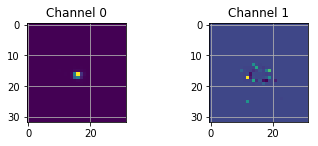

In [6]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0")
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1")
plt.grid(True)


plt.show()

## Define CNN Model

In [7]:
### Define CNN Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=1, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal')) #relu
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal')) #relu
model.add(Dropout(0.2))
model.add(Dense(1, activation='hard_sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        48        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

### Train the Model

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=5, min_lr=1.e-7) #val_loss #acc,loss,val_acc,val_loss,lr
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 2048 samples, validate on 2048 samples
Epoch 1/20
2048/2048 [==============================] - 14s 7ms/step - loss: 0.5034 - acc: 0.7432 - val_loss: 1.0919 - val_acc: 0.5864
Epoch 2/20
2048/2048 [==============================] - 13s 7ms/step - loss: 0.5013 - acc: 0.7480 - val_loss: 1.0913 - val_acc: 0.5854
Epoch 3/20
2048/2048 [==============================] - 13s 6ms/step - loss: 0.5060 - acc: 0.7461 - val_loss: 1.0912 - val_acc: 0.5854
Epoch 4/20
2048/2048 [==============================] - 13s 6ms/step - loss: 0.5096 - acc: 0.7402 - val_loss: 1.0914 - val_acc: 0.5854
Epoch 5/20
2048/2048 [==============================] - 13s 6ms/step - loss: 0.5029 - acc: 0.7412 - val_loss: 1.0915 - val_acc: 0.5854
Epoch 6/20
2048/2048 [==============================] - 14s 7ms/step - loss: 0.5021 - acc: 0.7383 - val_loss: 1.0916 - val_acc: 0.5845
Epoch 7/20
2048/2048 [==============================] - 13s 7ms/step - loss: 0.5031 - acc: 0.7363 - val_loss: 1.0917 - val_acc: 0.5850
Epoch 8

### Evaluate The Model

In [26]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

2048/2048 [==============================] - 3s 1ms/step

Validation loss / accuracy: 1.0920 / 0.5854
('Validation ROC AUC:', 0.62144756317138672)
2100/2100 [==============================] - 3s 1ms/step

Test loss / accuracy: 1.1179 / 0.5862
('Test ROC AUC:', 0.61542947845804996)


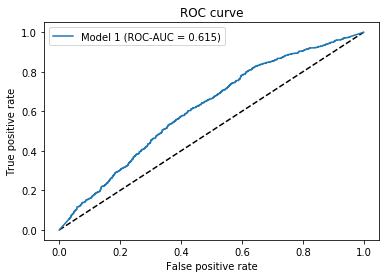

In [27]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()